<a href="https://colab.research.google.com/github/AryanSai/Deep-Learning/blob/main/Aryan_Sai_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Resnet

Here is the resnet architecture depiction from the original paper. Note that the input is assumed to be of an image of size 224 x 224. Further, every convolution is followed by batch normalization.

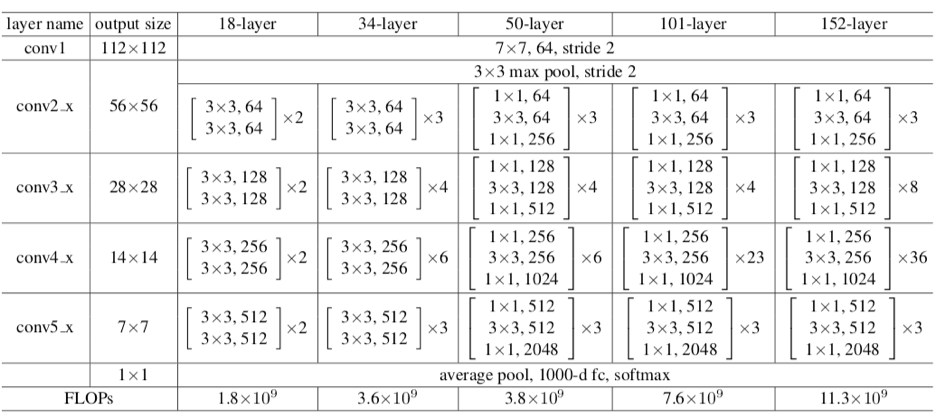

###Observation 1
All variants of resnet have the a common 7 x 7 convolution followed by max pool. We will group these operations under the class Layer1.


In [ ]:
import torch
import torch.nn as nn

In [ ]:
class Layer1(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = 64
        self.conv1 = nn.Conv2d(in_channels, out_channels = self.out_channels , kernel_size=7, stride=2, padding=3)
        self.batch_norm = nn.BatchNorm2d(self.out_channels)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.max_pool(x)
        return x

###More Observations
- All variants have four more layers namely conv2_x, ..., conv5_x.
- Each layer has multiple residual blocks consisting of couple or triple of convolutions.
- There are two types of residual block viz. one what we see in resnet-18 and resnet-34, and the other which is seen in resnet-50, resnet-101 and resnet-152. We will call the former BasicBlock and the latter BottleNeck.
- Layer2 (i.e conv2_x) retains the incoming spatial size (56 x 56). Other subsequent layers downsample the spatial size by a factor of 2 respectively.
- This downsampling is effected in the first convolution of first BasicBlock / second convolution of first Bottleneck within the layer using a stride of 2. Accordingly, along the skip connection in the first residual block in the layer, downsampling must be done(using a 1 x 1 convolution with a stride of 2).
- Other residual blocks within the layer retain the spatial size that is coming out of first residual block.
- When the layers are made up of residual blocks of type BasicBlock, in each layer (from layer 3 onwards), the number of feature maps / outchannels double from what it was in the previous layer. This doubling happens in the first convolution in the first BasicBlock of the layer. The second convolution in the first BasicBlock and the rest of the residual blocks of type BasicBlock retain the incoming number of feature maps. Accordingly, along the skip connection in the first BasicBlock of the layer, the number of channels must be doubled.
- When the layers are made up of residual blocks of type Bottleneck, in each layer (from layer 2 / 3 onwards), the number of feature maps increase by factor of 4 / 2 from what what comes out from the previous layer. This happens as follows. In the first Bottleneck in the layer, the first convolution reduces the incoming number of channels by 2 (except in layer 2 where the incoming number of channels is retained), the second convolution retains the number of channels coming from the first, and the third quadraples the incoming number of channels. The other blocks of type Bottleneck within the layer reduces by factor of 4 the incoming channels in the first convolution, retains the number of incoming channels in the second convolution and quadraples it in the third convolution. Note that along the skip connection in the first Bottleneck of the layer, the number of channels must be accordingly adjusted.

Based on the observations, first we will define BasicBlock.

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, is_first_block=False, is_layer_2=False, skip=True):
        super().__init__()

        self.in_channels = in_channels
        self.is_first_block = is_first_block
        self.is_layer_2 = is_layer_2
        self.skip = skip

        if is_layer_2:
          self.out_channels = in_channels
          self.stride = 1
        else:
          if is_first_block:
            self.out_channels = 2*in_channels
            self.stride = 2
          else:
            self.out_channels = in_channels
            self.stride = 1

        self.conv1 = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=self.stride, padding=1)
        self.bn1 = nn.BatchNorm2d(self.out_channels)
        self.conv2 = nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(self.out_channels)
        self.relu = nn.ReLU()

        if self.skip and not self.is_layer_2 and self.is_first_block:
            self.downsample_along_skip = True
            self.downsample_along_skip_conv = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=self.stride, padding=0)
            self.downsample_along_skip_bn = nn.BatchNorm2d(self.out_channels)
        else:
            self.downsample_along_skip = False

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample_along_skip:
            identity = self.downsample_along_skip_conv(x)
            identity = self.downsample_along_skip_bn(identity)
        out += identity
        out = self.relu(out)
        return out

Now we will define Bottleneck.

In [ ]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, is_first_block=False, is_layer_2=False, skip=True):
        super().__init__()

        self.in_channels = in_channels
        self.is_first_block = is_first_block
        self.is_layer_2 = is_layer_2
        self.skip = skip

        if is_layer_2:
          self.stride = 1
          if is_first_block:
            self.out_channels_1 = in_channels
          else:
            self.out_channels_1 = in_channels / 4
        else:
          self.stride = 2
          if is_first_block:
            self.out_channels_1 = in_channels / 2
          else:
            self.out_channels_1 = in_channels / 4

        self.out_channels = self.out_channels_1 * 4

        self.conv1 = nn.Conv2d(self.in_channels, self.out_channels_1, kernel_size=1, padding=0)
        self.bn1 = nn.BatchNorm2d(self.out_channels_1)
        self.conv2 = nn.Conv2d(self.out_channels_1, self.out_channels_1, kernel_size=3, stride=self.stride, padding=1)
        self.bn2 = nn.BatchNorm2d(self.out_channels_1)
        self.conv3 = nn.Conv2d(self.out_channels_1, self.out_channels, kernel_size=1, padding=0)
        self.bn3 = nn.BatchNorm2d(self.out_channels)
        self.relu = nn.ReLU()

        if self.skip and self.is_first_block:
            self.downsample_along_skip = True
            self.downsample_along_skip_conv = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=self.stride)
            self.downsample_along_skip_bn = nn.BatchNorm2d(self.out_channels)
        else:
            self.downsample_along_skip = False

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample_along_skip:
            identity = self.downsample_along_skip_conv(x)
            identity = self.downsample_along_skip_bn(identity)

        out += identity
        out = self.relu(out)
        return out


Now that we have coded our observations regarding BasicBlock and Bottleneck, we will define the ResNet as a network made up of layers of residual blocks.

In [ ]:
class ResNet(nn.Module):
  def __init__(self, res_block_type, num_blocks_per_layer, num_classes, in_channels=3, skip=True):
    # res_block_type is either BasicBlock or Bottleneck
    # num_blocks_per_layer is a list consisting of number of residual blocks in each layer from layer 2 to layer 5
    super().__init__()

    self.res_block_type = res_block_type
    self.num_blocks_per_layer = num_blocks_per_layer
    self.num_classes = num_classes
    self.skip=skip

    self.layer1 = Layer1(in_channels)
    self.layer2 = self._build_layer(res_block_type, num_blocks_per_layer[0], self.layer1.out_channels, True)
    self.layer3 = self._build_layer(res_block_type, num_blocks_per_layer[1], self.layer2[-1].out_channels, False)
    self.layer4 = self._build_layer(res_block_type, num_blocks_per_layer[2], self.layer3[-1].out_channels, False)
    self.layer5 = self._build_layer(res_block_type, num_blocks_per_layer[3], self.layer4[-1].out_channels, False)

    self.avg_pool = nn.AdaptiveAvgPool2d(1)
    self.fc_layer_in_channels = self.layer5[-1].out_channels
    self.fc = nn.Linear(self.fc_layer_in_channels, self.num_classes)

  def _build_layer(self, res_block_type, nblocks, in_channels, is_layer_2):
    layer = []
    for i in range(nblocks):
      is_first_block = (i == 0)
      block = res_block_type(in_channels, is_first_block, is_layer_2, self.skip)
      layer.append(block)
      in_channels = block.out_channels
    return nn.Sequential(*layer)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)
    out = self.avg_pool(out)
    out = out.view(out.size(0), -1)
    out = self.fc(out)
    return out


Let's now define resnet variants.

In [ ]:
def resnet18(in_channels=3, num_classes=10, skip=True):
  return ResNet(BasicBlock, [2, 2, 2, 2], num_classes, in_channels, skip)

def resnet34(in_channels=3, num_classes=10, skip=True):
  return ResNet(BasicBlock, [3, 4, 6, 3], num_classes, in_channels, skip)

def resnet50(in_channels=3, num_classes=10, skip=True):
  return ResNet(Bottleneck, [3, 4, 6, 3], num_classes, in_channels, skip)

def resnet101(in_channels=3, num_classes=10, skip=True):
  return ResNet(Bottleneck, [3, 4, 23, 3], num_classes, in_channels, skip)

def resnet152(in_channels=3, num_classes=10, skip=True):
  return ResNet(Bottleneck, [3, 8, 36, 3], num_classes, in_channels, skip)

model = resnet34(num_classes=1000)

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Layer1-5           [-1, 64, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]          36,928
       BatchNorm2d-7           [-1, 64, 56, 56]             128
              ReLU-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,928
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
       BasicBlock-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          36,928
      BatchNorm2d-14           [-1, 64,

Let's train resnet on MNIST dataset.

First, we will download the dataset and set up the train and test loaders.

In [ ]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.Resize(224), transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='/content/drive/MyDrive/100_utilities/datasets', download=True, train=True, transform=transform)
testset = torchvision.datasets.MNIST(root='/content/drive/MyDrive/100_utilities/datasets', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

Next, we will define the model, loss criterion and the optimizer.

In [ ]:
import torch.optim as optim

model = resnet34(in_channels=1, num_classes=10)
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.SGD(params=model.parameters(), lr=0.01)

Let's define the train loop.

In [ ]:
import torch.nn.functional as F
from tqdm import tqdm

def train_epoch(model, criterion, optimizer, train_loader, val_loader, epoch, device):
  loss_train, loss_val = 0., 0.
  acc_train, acc_val = 0., 0.
  ntrain = len(train_loader.dataset)
  nval = len(val_loader.dataset)

  with tqdm(train_loader, unit='batches') as pbar:
    for i, (images, labels) in enumerate(pbar):
      pbar.set_description(f"Epoch {epoch}")
      images = images.to(device)
      labels = labels.to(device).to(torch.long).view(-1)

      # train and back-propagate
      optimizer.zero_grad()
      output = model(images)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()

      # train accuracy
      with torch.no_grad():
        probs = F.softmax(output, dim=1).cpu()
        preds = torch.max(probs, dim=1)[1]
        acc_train += (preds == labels.cpu()).sum()
        loss_train += loss.item()

      #validate
      if i%100 == 0 or i == len(train_loader) - 1:
        loss_val, acc_val = validate(model, criterion, val_loader, device)

      if i < len(train_loader) - 1:
        denom = images.shape[0] * (i+1)
      else:
        denom = ntrain

      pbar.set_postfix(train_loss=loss_train/denom, valid_loss=loss_val/nval, train_acc=acc_train/denom, valid_acc=acc_val/nval)

  return loss_train/ntrain, loss_val/nval, acc_train/ntrain, acc_val/nval

def validate(model, criterion, val_loader, device):
  acc_val = 0.
  loss_val = 0.
  with torch.no_grad():
    for val_images, val_labels in val_loader:
      val_images = val_images.to(device)
      val_labels = val_labels.to(device).to(torch.long).view(-1)

      val_output = model(val_images)
      val_loss = criterion(val_output, val_labels)
      loss_val += val_loss.item()

      probs = F.softmax(val_output, dim=1).cpu()
      preds = torch.max(probs, dim=1)[1]
      acc_val += (preds == val_labels.cpu()).sum()

  return loss_val, acc_val

def train(model, criterion, optimizer, train_loader, val_loader, epochs, device):
  train_losses = []
  val_losses = []
  train_accs = []
  val_accs = []

  for epoch in range(epochs):
    train_loss, val_loss, train_acc, val_acc = train_epoch(model, criterion, optimizer, train_loader, val_loader, epoch, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

  return train_losses, val_losses, train_accs, val_accs


Let's port the model and criterion to gpu, if available. Then train the model.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
citerion = criterion.to(device)
epochs = 10

train_losses, val_losses, train_accs, val_accs = train(model, criterion, optimizer, trainloader, testloader, epochs, device)

Epoch 0:   0%|          | 0/469 [15:19<?, ?batches/s]


KeyboardInterrupt: 

Let's define a plain net -  a network without skip connections.

In [ ]:
plain_model = resnet34(num_classes=1000, skip=False)
#summary(plain_model, input_size=(3, 224, 224))